# Functions

In [23]:
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


# Color definitions
color_LF = 'xkcd:muted blue'
color_NLF = 'xkcd:coral pink'
color_NLF2 = '#60AB9E'
color_NLF3 = '#BEBC48'
color_RNN = '#A778B4'

plt.rcParams.update({
    # Your existing parameters
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    
    # Additional parameters
    'figure.figsize': (10, 6),  # Default figure size
    'figure.dpi': 100,  # Figure resolution
    
    # Tick parameters
    'xtick.major.size': 5,  # Major tick length
    'xtick.minor.size': 3,  # Minor tick length
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'xtick.major.width': 1.5,  # Major tick width
    'xtick.minor.width': 1,  # Minor tick width
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1,
    'xtick.direction': 'out',  # Tick direction
    'ytick.direction': 'out',
    
    # Grid parameters
    'grid.linewidth': 0.5,
    'grid.alpha': 0.3,
    
    # Line parameters
    'lines.linewidth': 2,
    'lines.markersize': 8,
    
    # Font family
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    
    # Legend parameters
    'legend.framealpha': 0.8,
    'legend.edgecolor': '0.8',
    
    # Figure layout
    'figure.autolayout': True,  # Adjusts subplot params for tight layout
    
    # Saving parameters
    'savefig.dpi': 300,  # DPI for saved figures
    'savefig.format': 'png',  # Default save format
    
    # Axes parameters
    'axes.linewidth': 1.5,  # Width of axes lines
    'axes.grid': True,  # Show grid by default
    'axes.axisbelow': True,  # Grid should be below other plot elements
})

# Your existing parameters
plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False



RNN_path = os.path.join(os.getcwd(), 'RNN')
NLFw_path = os.path.join(os.getcwd(), 'NLFw')
NLF_path = os.path.join(os.getcwd(), 'NLF')
LF_path = os.path.join(os.getcwd(), 'LF')
seeds = [1000, 2000, 3000, 4000, 5000]
# Define custom exception when file is not found
class NoFilesFoundError(Exception):
    """Exception raised when no fusion run files are found."""
    pass
    
def load_rnn_accuracies(base_path=RNN_path, seeds=[1000, 2000, 3000, 4000, 5000], steps=500, k_range=range(1, 9), include_levy=False, eql_distr=False, stats=False):
    """
    Load RNN accuracies from pickle files and summarize the results.

    This function loads RNN accuracy data from pickle files, either for regular k-based (i.e., Non-Levy) files
    or Levy-based files, depending on the parameters. It then summarizes the data using the
    RNN_summary function.

    Args:
        base_path (str): The base path where the RNN files are stored. Default is RNN_path.
        seeds (list): A list of random seeds used in the RNN training. Default is [1000, 2000, 3000, 4000, 5000].
        steps (int): The number of steps used in the RNN training and testing. Default is 500.
        k_range (range): The range of k values to consider for regular k-based files. Default is range(1, 9).
        include_levy (bool): If True, load Levy-based files instead of regular k-based files. Default is False.
        eql_distr (bool): If True and include_levy is True, load equal distribution Levy files. Default is False.
        stats (bool): If True, include statistical analysis in the summary. Default is False.

    Returns:
        pandas.DataFrame: A DataFrame containing the summarized RNN accuracy data.

    Raises:
        NoFilesFoundError: If no matching RNN files are found in the specified path.
    """

    #print(f"Debug: include_levy is {include_levy}")  # Debug print
    all_runs = {}
    
    if not include_levy:
        print("Loading non-Levy files")  # Debug print
        # Regular k-based files
        for seed in seeds:
            for k in k_range:
                file_path = os.path.join(base_path, f'RNN_train_k_{k}_seed_{seed}_{steps}steps_testaccuracies.pkl')
                if os.path.exists(file_path):
                    with open(file_path, 'rb') as file:
                        data = pkl.load(file)
                        
                        for key, value in data.items():
                            if key not in all_runs:
                                all_runs[key] = []
                            all_runs[key].append(value)
                else:
                    raise NoFilesFoundError(f"No file found in {base_path} with seed={seed} and steps={steps}")              
    
    else:
        print("Loading Levy files")  # Debug print
        # Levy files
        for seed in seeds:
            if eql_distr:
                if seed == 1000:
                    print("Loading equal distribution k Levy files")  # Debug print
                file_path = os.path.join(base_path, f'RNN_train_levy_seed_{seed}_{steps}steps_eqldistr_k_testaccuracies.pkl')
            else:
                file_path = os.path.join(base_path, f'RNN_train_levy_seed_{seed}_{steps}steps_testaccuracies.pkl')
            
            if os.path.exists(file_path):
                with open(file_path, 'rb') as file:
                    data = pkl.load(file)
                    
                    for key, value in data.items():
                        if key not in all_runs:
                            all_runs[key] = []
                        all_runs[key].append(value)
            else:
                raise NoFilesFoundError(f"No file found in {base_path} with seed={seed} and steps={steps}")
    
    print(f"Number of items in all_runs: {len(all_runs)}")  # Debug print
    df = RNN_summary(all_runs, stats)
    return df


def RNN_summary(datadict, stats=False):
    """
    Summarize RNN accuracy data and optionally calculate statistics.

    This function takes a dictionary of RNN accuracy data and converts it into a pandas DataFrame.
    If stats is True, it calculates mean and standard deviation of accuracies for each train-test pair.

    Args:
        datadict (dict): A dictionary containing RNN accuracy data.
            The keys are tuples of (train, test), and the values are lists of accuracies.
        stats (int): If True, calculate and return statistics. Otherwise, return the raw data. Default is False.

    Returns:
        pandas.DataFrame: A DataFrame containing either the raw accuracy data or summary statistics,
                          depending on the value of the 'stats' parameter.
    """

    # Create DataFrame
    df = pd.DataFrame([(k[0], k[1], v) for k, v in datadict.items()], 
                      columns=['train', 'test', 'accuracy'])
    # Explode the accuracy list
    df = df.explode('accuracy')
    
    if stats:
        # Calculate statistics
        stats_df = df.groupby(['train', 'test'])['accuracy'].agg(['mean', lambda x: np.std(x, ddof=1)]).reset_index()
        stats_df.columns = ['train', 'test', 'mean_accuracy', 'std_accuracy']
        return stats_df
    else:
        return df
    

def load_fusion_accuracies(base_path=NLFw_path, steps=500, k_range=range(1, 9), include_levy=False, eql_distr=False):
    """
    Load NLFw (Non-Linear Fusion with sliding time windows), NLF or LF accuracies from pickle files and summarize the results.

    This function loads accuracy data from a single pickle file, which can be either for regular k-based (i.e., Non-Levy) data,
    Levy-based data, or equal distribution Levy-based data, depending on the parameters. It then summarizes the data
    using the fusion_summary function.

    Args:
        base_path (str): The base path where the files are stored. Default is NLFw_path.
        steps (int): The number of steps used in the fusion training. Default is 500.
        k_range (range): The range of k values to consider. Default is range(1, 9). (Note: This parameter is unused in the function body)
        include_levy (bool): If True, load Levy-based file instead of regular k-based file. Default is False.
        eql_distr (bool): If True and include_levy is True, load equal distribution Levy file. Default is False.

    Returns:
        pandas.Dictionary: A Dictionary containing the summarized accuracy data.

    Raises:
        NoFilesFoundError: If no matching fusion file is found in the specified path.
    """

    all_runs = {}
    if not include_levy:
        print("Loading non-Levy files")  # Debug print
        # Regular k-based files
        file_path = os.path.join(base_path, f'classifier_accuracies_{steps}steps.pkl')
    elif eql_distr:
        file_path = os.path.join(base_path, f'classifier_accuracies_{steps}steps_levy_eqldistr_k.pkl')
    else:
        file_path = os.path.join(base_path, f'classifier_accuracies_{steps}steps_levy.pkl')
        
    if os.path.exists(file_path):
        with open(file_path, 'rb') as file:
            data = pkl.load(file)
            
            for key, value in data.items():
                if key not in all_runs:
                    all_runs[key] = []
                all_runs[key].append(value)
            
    else:
        raise NoFilesFoundError(f"No file found in {base_path} with steps={steps}")     
    print(f"Number of items in all_runs: {len(all_runs)}")  # Debug print
    df = fusion_summary(all_runs)
    return df

    
def fusion_summary(datadict, accuracy_mult_by_100=True):
    """
    Summarize NLFw (Non-Linear Fusion with sliding time windows), NLF or LF accuracy data.

    This function takes a dictionary of accuracy data, converts it into a pandas DataFrame,
    and calculates accuracies for each combination of train, test, and window size. 

    Args:
        datadict (dict): A dictionary containing accuracy data.
            The keys are tuples of (train, windowsize, test), and the values are lists of accuracies.
        accuracy_mult_by_100 (bool): If True, multiply the mean accuracy by 100. Default is True.
    

    Returns:
        dict: A dictionary where keys are window sizes and values are pandas DataFrames.
              Each DataFrame contains accuracies for the corresponding window size.
    """
       
    # Create DataFrame
    df = pd.DataFrame([(k[0], k[1], k[2], v) for k, v in datadict.items()], 
                      columns=['train', 'windowsize', 'test', 'accuracy'])
    
    # Explode the accuracy list
    df = df.explode('accuracy')
    
    # Get unique window sizes
    windowsizes = df['windowsize'].unique()
    
    # Split the DataFrame based on windowsize
    dfs = {ws: df[df['windowsize'] == ws] for ws in windowsizes}
    
    # Calculate statistics for each split DataFrame
    stats_dfs = {}
    
    for ws, split_df in dfs.items():
        stats_df = split_df.groupby(['train', 'test'])['accuracy'].agg(['mean']).reset_index()
        stats_df.columns = ['train', 'test', 'mean_accuracy']
        if accuracy_mult_by_100:
            stats_df['mean_accuracy'] *= 100
        stats_df['std_accuracy'] = None # Required column for plotting functionality
        stats_dfs[ws] = stats_df
    return stats_dfs

RNN_nonlevy = load_rnn_accuracies(steps=500, include_levy=0, eql_distr=0, stats=1)
#RNN_levy = load_rnn_accuracies(steps=500, include_levy=1, eql_distr=0, stats=1)
#RNN_levy_eqldistr = load_rnn_accuracies(steps=500, include_levy=1, eql_distr=1, stats=1)

NLFw_nonlevy = load_fusion_accuracies(steps=500, include_levy=0, eql_distr=0)
#NLFw_levy = load_fusion_accuracies(steps=500, include_levy=1, eql_distr=0)
#NLFw_levy_eqldistr = load_fusion_accuracies(steps=500, include_levy=1, eql_distr=1)

LF_nonlevy = load_fusion_accuracies(base_path=LF_path, steps=500, include_levy=0, eql_distr=0)
#LF_levy = load_fusion_accuracies(base_path=LF_path, steps=500, include_levy=1, eql_distr=0)
#LF_levy_eqldistr = load_fusion_accuracies(base_path=LF_path, steps=500, include_levy=1, eql_distr=1)

NLF_nonlevy = load_fusion_accuracies(base_path=NLF_path, steps=500, include_levy=0, eql_distr=0)
#NLF_levy = load_fusion_accuracies(base_path=NLF_path, steps=500, include_levy=1, eql_distr=0)
#NLF_levy_eqldistr = load_fusion_accuracies(base_path=NLF_path, steps=500, include_levy=1, eql_distr=1)

Loading non-Levy files
Number of items in all_runs: 64
Loading non-Levy files
Number of items in all_runs: 128
Loading non-Levy files
Number of items in all_runs: 64
Loading non-Levy files
Number of items in all_runs: 64


In [262]:
#plt.style.use('./style_sheet.mplstyle')


Bad key axes.ylim.top in file ./style_sheet.mplstyle, line 28 ('axes.ylim.top : 90    # Added y-axis upper limit')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.8.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key axes.ylim.bottom in file ./style_sheet.mplstyle, line 29 ('axes.ylim.bottom : 75 # Added y-axis lower limit')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.8.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key 'grid.linewidth' in file ./style_sheet.mplstyle, line 57 ("'grid.linewidth': 0.5,")
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.8.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key 'grid.alpha' in file ./style_sheet.mplstyle, line 58 ("'grid.alpha': 0.3,")
You probabl

In [2]:
# COPY
def plot_with_shaded_errors_all(df, ax=None, title='Accuracy', label=None, shade_color='blue', alpha=0.2, show_lines=False, show_markers=False, add_colorbar=True):
    # Check if necessary columns exist
    required_columns = ['test', 'mean_accuracy', 'train']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame")
    
    # Ensure mean_accuracy is numeric
    df['mean_accuracy'] = pd.to_numeric(df['mean_accuracy'], errors='coerce')
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    unique_trains = sorted(df['train'].unique())
    
    # Create a color map for the gradient
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=min(unique_trains), vmax=max(unique_trains))
    
    # Sort the dataframe by train and test
    df_sorted = df.sort_values(['train', 'test'])
    
    # Create shaded region between min and max accuracies
    min_accuracies = df_sorted.groupby('test')['mean_accuracy'].min()
    max_accuracies = df_sorted.groupby('test')['mean_accuracy'].max()
    ax.fill_between(min_accuracies.index, min_accuracies, max_accuracies,
                    alpha=alpha, color='gray' if shade_color is None else shade_color, label=label)
    
    if show_lines or show_markers:
        for train_value in unique_trains:
            subset = df_sorted[df_sorted['train'] == train_value]
            plot_color = cmap(norm(train_value))
            
            if show_lines and show_markers:
                ax.plot(subset['test'], subset['mean_accuracy'], 
                        linestyle='-', marker='o',
                        color=plot_color,
                        label=f'Train {train_value}')
            elif show_lines:
                ax.plot(subset['test'], subset['mean_accuracy'], 
                        linestyle='-', 
                        color=plot_color,
                        label=f'Train {train_value}')
            
            if show_markers:
                ax.scatter(subset['test'], subset['mean_accuracy'], 
                           color=plot_color)
    

    # Set custom x-ticks and labels
    custom_xticks = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
    custom_xlabels = ['Lévy', 'Uniform', '1', '2', '3', '4', '5', '6', '7', '8']
    ax.set_xticks(custom_xticks)
    ax.set_xticklabels(custom_xlabels)

    # Rotate labels if needed for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    ax.set_ylim((75,90))
    ax.set_xlabel('Test')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.grid(True)
    
    if label:
        ax.legend()
    
    # Add colorbar if requested
    if add_colorbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, label='Train Value')
        cbar.set_ticks(unique_trains)
    
    return ax
# Plot all train-test scenarios with error bars
def plot_with_error_bars(df, ax=None, title=None, label=None, color=None):
    # Check if necessary columns exist
    required_columns = ['test', 'mean_accuracy', 'train']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame")
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    unique_trains = df['train'].unique()
    print(unique_trains)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_trains)))
    color_map = dict(zip(unique_trains, colors))
    
    for train_value in unique_trains:
        subset = df[df['train'] == train_value]
        
        plot_color = color if color else color_map[train_value]
        
        # Plot the line first
        ax.plot(subset['test'], subset['mean_accuracy'], 
                linestyle='-', 
                color=plot_color,
                label=label if label else f'{train_value}')
        
        # Check if std_accuracy column exists and is not all None/NaN
        if 'std_accuracy' in df.columns and not subset['std_accuracy'].isna().all():
            ax.errorbar(subset['test'], subset['mean_accuracy'], 
                        yerr=subset['std_accuracy'],
                        fmt='|', 
                        capsize=2,
                        capthick=1,
                        elinewidth=2,
                        color=plot_color)
    
    ax.set_xlabel('Test')
    ax.set_ylabel('Mean Accuracy')
    ax.set_title(title)
    ax.legend()
    #ax.grid(True)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='Train', ncol=2)
    ax.set_ylim(76, 90)
    return ax

#plot_with_error_bars(RNN_nonlevy, title='RNN')

# Load

### NLFw

In [3]:
train_values = [1, 2, 3, 4, 5, 6, 7, 8]
df = NLF_nonlevy['NLF_1'][NLF_nonlevy['NLF_1']['train'].isin(train_values)]
df2 = NLFw_nonlevy[2][NLFw_nonlevy[2]['train'].isin(train_values)]
df3 = NLFw_nonlevy[3][NLFw_nonlevy[3]['train'].isin(train_values)]
dfrnn = RNN_nonlevy[RNN_nonlevy['train'].isin(train_values)]

In [4]:
datalevy = np.load('./NLFw/NLFw_classifier_testmetrics_testedonlevy_trainedonk.pkl', allow_pickle=True)
datalevyeq = np.load('./NLFw/NLFw_classifier_testmetrics_testedonlevy_eq_trainedonk.pkl', allow_pickle=True)

def split_NLFw_onlevy(data_dict):
    
    # Initialize empty dictionaries for the split data
    data_2 = {}
    data_3 = {}

    # Split the data based on the second item of the key
    for key, value in data_dict.items():
        if key[1] == 2:
            data_2[key] = value
        elif key[1] == 3:
            data_3[key] = value

    # Create dataframes from the split data
    NLFw_onlevy_2 = pd.DataFrame.from_dict(data_2, orient='index')
    NLFw_onlevy_3 = pd.DataFrame.from_dict(data_3, orient='index')

    return NLFw_onlevy_2, NLFw_onlevy_3

NLFw_onlevy2, NLFw_onlevy3 = split_NLFw_onlevy(datalevy)
NLFw_onlevyeq2, NLFw_onlevyeq3 = split_NLFw_onlevy(datalevyeq)

##NLFw_onlevy2#['accuracy'].values
accuracies = NLFw_onlevy2['accuracy'].values * 100

new_rows = pd.DataFrame({
    'train': [1,2,3,4,5,6,7,8],
    'test': [-1] * len(accuracies),
    'mean_accuracy': accuracies,
    'std_accuracy': [None] * len(accuracies)
})
combined_df2 = pd.concat([new_rows, df2], ignore_index=True)

accuracies = NLFw_onlevyeq2['accuracy'].values * 100
new_rows = pd.DataFrame({
    'train': [1,2,3,4,5,6,7,8],
    'test': [0] * len(accuracies),
    'mean_accuracy': accuracies,
    'std_accuracy': [None] * len(accuracies)
})
combined_df2 = pd.concat([new_rows, combined_df2], ignore_index=True)



NLFw_onlevy3#['accuracy'].values
accuracies = NLFw_onlevy3['accuracy'].values * 100
new_rows = pd.DataFrame({
    'train': [1,2,3,4,5,6,7,8],
    'test': [-1] * len(accuracies),
    'mean_accuracy': accuracies,
    'std_accuracy': [None] * len(accuracies)
})
combined_df3 = pd.concat([new_rows, df3], ignore_index=True)

NLFw_onlevy3#['accuracy'].values
accuracies = NLFw_onlevyeq3['accuracy'].values * 100
new_rows = pd.DataFrame({
    'train': [1,2,3,4,5,6,7,8],
    'test': [0] * len(accuracies),
    'mean_accuracy': accuracies,
    'std_accuracy': [None] * len(accuracies)
})
combined_df3 = pd.concat([new_rows, combined_df3], ignore_index=True)

In [5]:
NLFw_levy_ktested = np.load('./NLFw/NLFw_classifier_testmetrics_testedonk_trainedonlevy.pkl', allow_pickle=True)
NLFw_levy2_ktested, NLFw_levy3_ktested = split_NLFw_onlevy(NLFw_levy_ktested)

NLFw_levy_levytested = np.load('./NLFw/NLFw_classifier_testmetrics_testedonlevy_trainedlevy.pkl', allow_pickle=True)
NLFw_levy2_levytested, NLFw_levy3_levytested = split_NLFw_onlevy(NLFw_levy_levytested)

NLFw_levy_levyeqtested = np.load('./NLFw/NLFw_classifier_testmetrics_testedonlevy_eq_trainedlevy.pkl', allow_pickle=True)
NLFw_levy2_levyeqtested, NLFw_levy3_levyeqtested = split_NLFw_onlevy(NLFw_levy_levytested)



NLFw_levy_eq_ktested = np.load('./NLFw/NLFw_classifier_testmetrics_testedonk_trainedonlevy_eq.pkl', allow_pickle=True)
NLFw_levy2_eq_ktested, NLFw_levy3_eq_ktested = split_NLFw_onlevy(NLFw_levy_eq_ktested)

NLFw_levy_eq_levytested = np.load('./NLFw/NLFw_classifier_testmetrics_testedonlevy_trainedonlevy_eq.pkl', allow_pickle=True)
NLFw_levy2_eq_levytested, NLFw_levy3_eq_levytested = split_NLFw_onlevy(NLFw_levy_eq_levytested)

NLFw_levy_eq_levyeqtested = np.load('./NLFw/NLFw_classifier_testmetrics_testedonlevy_eq_trainedonlevy_eq.pkl', allow_pickle=True)
NLFw_levy2_eq_levyeqtested, NLFw_levy3_eq_levyeqtested = split_NLFw_onlevy(NLFw_levy_levytested)

In [6]:
NLFw_2_eq = np.zeros(10)
NLFw_2_eq[0] = NLFw_levy2_eq_levytested['accuracy'].values
NLFw_2_eq[1] = NLFw_levy2_eq_levyeqtested['accuracy'].values
NLFw_2_eq[2:] = NLFw_levy2_eq_ktested['accuracy'].values
NLFw_2_eq = NLFw_2_eq * 100
np.save('NLF2_levyeqtrained_alltest.npy', NLFw_2_eq)

/tmp/ipykernel_2155/435240337.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  NLFw_2_eq[0] = NLFw_levy2_eq_levytested['accuracy'].values
/tmp/ipykernel_2155/435240337.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  NLFw_2_eq[1] = NLFw_levy2_eq_levyeqtested['accuracy'].values


In [7]:
NLFw_3_eq = np.zeros(10)
NLFw_3_eq[0] = NLFw_levy3_eq_levytested['accuracy'].values
NLFw_3_eq[1] = NLFw_levy3_eq_levyeqtested['accuracy'].values
NLFw_3_eq[2:] = NLFw_levy3_eq_ktested['accuracy'].values
NLFw_3_eq = NLFw_3_eq * 100
np.save('NLF3_levyeqtrained_alltest.npy', NLFw_3_eq)

/tmp/ipykernel_2155/2928948107.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  NLFw_3_eq[0] = NLFw_levy3_eq_levytested['accuracy'].values
/tmp/ipykernel_2155/2928948107.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  NLFw_3_eq[1] = NLFw_levy3_eq_levyeqtested['accuracy'].values


In [8]:
NLFw_2 = np.zeros(10)
NLFw_2[0] = NLFw_levy2_levytested['accuracy'].values
NLFw_2[1] = NLFw_levy2_levyeqtested['accuracy'].values
NLFw_2[2:] = NLFw_levy2_ktested['accuracy'].values
NLFw_2 = NLFw_2 * 100
np.save('NLF2_levytrained_alltest.npy', NLFw_2)

/tmp/ipykernel_2155/3425270097.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  NLFw_2[0] = NLFw_levy2_levytested['accuracy'].values
/tmp/ipykernel_2155/3425270097.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  NLFw_2[1] = NLFw_levy2_levyeqtested['accuracy'].values


In [9]:
NLFw_3 = np.zeros(10)
NLFw_3[0] = NLFw_levy3_levytested['accuracy'].values
NLFw_3[1] = NLFw_levy3_levyeqtested['accuracy'].values
NLFw_3[2:] = NLFw_levy3_ktested['accuracy'].values
NLFw_3 = NLFw_3 * 100
np.save('NLF3_levytrained_alltest.npy', NLFw_3)

/tmp/ipykernel_2155/749759465.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  NLFw_3[0] = NLFw_levy3_levytested['accuracy'].values
/tmp/ipykernel_2155/749759465.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  NLFw_3[1] = NLFw_levy3_levyeqtested['accuracy'].values


In [10]:
print(NLFw_2_eq)
print(NLFw_3_eq)
print(NLFw_2)
print(NLFw_3)

[82.8 83.4 80.4 84.3 84.6 84.5 84.3 84.3 84.3 84.2]
[82.3 83.6 78.6 81.9 85.3 86.4 86.5 86.3 86.8 86.9]
[83.4 83.4 82.3 84.3 84.4 84.1 84.  83.6 83.7 83.7]
[83.6 83.6 81.7 83.4 85.2 85.5 85.6 85.4 85.4 85.6]


### RNN

#### k-trained

In [11]:
datalevy = np.load('../RNN/RNN_testonlevy_trainonk.npy', allow_pickle=True).item()
datalevyeq = np.load('../RNN/RNN_testonlevyeq_trainonk.npy', allow_pickle=True).item()

data = {
    'train': list(range(1, 9)),  # 1 through 8
    'test': [-1] * 8,  # -1 repeated 8 times
    'mean_accuracy': [np.mean(values) for values in datalevy.values()],
    'std_accuracy': [np.std(values, ddof=1) for values in datalevy.values()]
}

dflevy = pd.DataFrame(data)

data = {
    'train': list(range(1, 9)),  # 1 through 8
    'test': [0] * 8,  # -1 repeated 8 times
    'mean_accuracy': [np.mean(values) for values in datalevyeq.values()],
    'std_accuracy': [np.std(values, ddof=1) for values in datalevyeq.values()]
}

dflevyeq = pd.DataFrame(data)

combined_dfrnn = pd.concat([dflevy, dflevyeq, RNN_nonlevy], axis=0, ignore_index=True)
combined_dfrnn

,train,test,mean_accuracy,std_accuracy
0,1,-1,82.515,0.102755
1,2,-1,82.95,0.156187
2,3,-1,83.49875,0.117044
3,4,-1,83.31125,0.248055
4,5,-1,83.2775,0.219979
...,...,...,...,...
75,8,4,84.57,0.881376
76,8,5,85.9875,1.033085
77,8,6,86.6575,1.128159
78,8,7,87.45,0.830227


#### levy/flat trained

In [12]:
RNN_levy_levytested = np.load('../RNN/RNN_testonlevy_trainonlevy.npy', allow_pickle=True)

RNN_levy_levyeqtested = np.load('../RNN/RNN_testonlevyeq_trainonlevy.npy', allow_pickle=True)


RNN_levy_eq_levytested = np.load('../RNN/RNN_testonlevy_trainonlevyeq.npy', allow_pickle=True)

RNN_levy_eq_levyeqtested = np.load('../RNN/RNN_testonlevyeq_trainonlevyeq.npy', allow_pickle=True)

In [16]:
import pickle as pkl
# Initialize consolidated dictionary with empty lists for keys 1-8
consolidated_dict_levy = {i: [] for i in range(1, 9)}

# Loop through seeds and load data
for seed in [1000, 2000, 3000, 4000, 5000]:
    path = f'../RNN/RNN_train_onlevy_seed_{seed}_500steps_testaccuracies.pkl'
    with open(path, 'rb') as file:
        data = pkl.load(file)
        # Extract values for each key (1-8) and append to consolidated dict
        for key in range(1, 9):
            value = data[('levy', key)]
            consolidated_dict_levy[key].append(value)
consolidated_dict_levy[-1] = RNN_levy_levytested
consolidated_dict_levy[0] = RNN_levy_levyeqtested

In [17]:
RNN_levy_levytested

array([82.14375, 82.04375, 82.34375, 82.2375 , 82.13125])

In [18]:
import pickle 

# Initialize consolidated dictionary with empty lists for keys 1-8
consolidated_dict_levyeq = {i: [] for i in range(1, 9)}

# Loop through seeds and load data
for seed in [1000, 2000, 3000, 4000, 5000]:
    path = f'../RNN/RNN_train_onlevyeq_seed_{seed}_500steps_testaccuracies.pkl'
    with open(path, 'rb') as file:
        data = pickle.load(file)
        # Extract values for each key (1-8) and append to consolidated dict
        for key in range(1, 9):
            value = data[('levy', key)]
            consolidated_dict_levyeq[key].append(value)
consolidated_dict_levyeq[-1] = RNN_levy_eq_levytested
consolidated_dict_levyeq[0] = RNN_levy_eq_levyeqtested

In [277]:
consolidated_dict_levy

{1: [82.78750000000001, 82.83125, 83.23125, 83.40625, 82.70625],
 2: [83.36875, 82.7125, 83.44375000000001, 82.95, 82.9125],
 3: [83.0625, 82.9375, 82.92500000000001, 83.54375, 83.11874999999999],
 4: [82.875,
  82.19999999999999,
  82.64375000000001,
  82.61874999999999,
  82.66250000000001],
 5: [82.23125, 81.575, 82.51875, 83.05, 82.24375],
 6: [82.3875, 81.5875, 82.31875, 82.6375, 82.35],
 7: [82.26875, 81.45, 82.1875, 83.03125, 82.2375],
 8: [81.85, 81.2375, 82.425, 82.5875, 82.55624999999999],
 -1: array([82.14375, 82.04375, 82.34375, 82.2375 , 82.13125]),
 0: array([81.99375, 81.525  , 82.03125, 82.3875 , 81.98125])}

In [278]:
consolidated_dict_levyeq

{1: [82.30625, 82.2375, 82.525, 83.10625, 81.65625],
 2: [82.93125, 83.5375, 83.46875, 83.85000000000001, 83.1],
 3: [83.75625, 84.0625, 84.1125, 83.6375, 84.56875000000001],
 4: [84.475, 84.7125, 83.625, 83.6375, 85.04374999999999],
 5: [84.03125, 84.6, 83.96875, 83.6875, 85.74374999999999],
 6: [84.53125, 84.90625, 84.06875000000001, 82.89999999999999, 85.79375],
 7: [84.925, 84.3, 83.875, 83.65, 86.29375],
 8: [84.6375, 84.65625, 83.85625, 83.35625, 86.925],
 -1: array([82.73125, 82.725  , 82.64375, 82.79375, 83.0375 ]),
 0: array([83.64375, 83.9    , 83.56875, 83.1875 , 84.8125 ])}

In [279]:
np.save('RNN_levytrained_alltest.npy', consolidated_dict_levy)
np.save('RNN_levyeqtrained_alltest.npy', consolidated_dict_levyeq)

# Plot

In [280]:
NLFw_2

array([83.4, 83.4, 82.3, 84.3, 84.4, 84.1, 84. , 83.6, 83.7, 83.7])

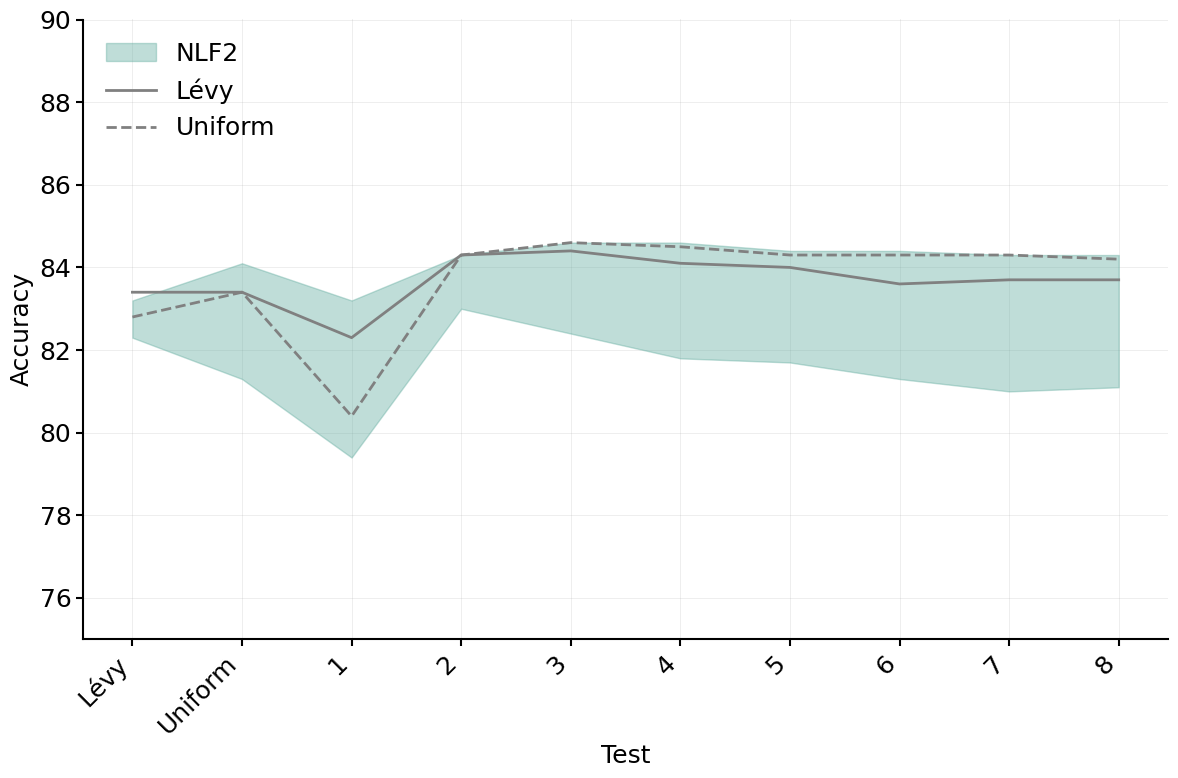

In [31]:
# Create a figure with subplots
#fig, axs = plt.subplots(1, 1, figsize=(20, 15)) #3, 2
#axs = axs.flatten()  # Flatten the 2D array of axes to make it easier to iterate

# List of datasets and their corresponding properties
datasets = [
    #(LF_nonlevy['LF'], 'LF', 'green', LF_levy['LF']),
    #(df, 'NLF', 'grey', NLF_levy['NLF_1']),
    #(df2, 'NLF2', 'blue', NLFw_levy[2]),
    #(df3, 'NLF3', 'red', NLFw_levy[3]),
    #(combined_dfrnn, 'RNN', color_RNN, consolidated_dict_levy, consolidated_dict_levyeq, 0.4),
    (combined_df2, 'NLF2', color_NLF2, NLFw_2, NLFw_2_eq, 0.4),
    #(combined_df3, 'NLF3', color_NLF3, NLFw_3, NLFw_3_eq, 0.4)
]

# Plot each dataset in its own subplot
for i, (data, label, color, levy, levy_eq, alpha) in enumerate(datasets):
    ax = plot_with_shaded_errors_all(
        data, 
        #ax=axs[i], 
        title=None,
        label=label, 
        shade_color=color,
        show_lines=0,  # Set to False if you don't want to show lines
        show_markers=0,  # Set to False if you don't want to show markers
        add_colorbar=0,  # Set to False if you don't want to add the colorbar
        alpha=alpha
    )
    
    #plot_with_error_bars(levy, ax=ax, title=None)
    #print(NLFw_2)
    if label == 'RNN':
        # Calculate means and standard deviations
        means = [np.mean(consolidated_dict_levy[key]) for key in range(-1, 9)]
        stds = [np.std(consolidated_dict_levy[key], ddof=1) for key in range(-1, 9)]
        
        # Create the plot
        
        ax.errorbar(range(-1, 9), means, yerr=stds, 
                   fmt='-',  # 'o-' means line with dots
                   capsize=5,  # adds caps to error bars
                   capthick=2,  # thickness of caps
                   elinewidth=1,  # thickness of error bar lines
                   markersize=8,  # size of dots
                   color='grey',
                   linewidth=2, label='Lévy')  # thickness of connecting line
        
        # Calculate means and standard deviations
        means = [np.mean(consolidated_dict_levyeq[key]) for key in range(-1, 9)]
        stds = [np.std(consolidated_dict_levyeq[key], ddof=1) for key in range(-1, 9)]
        
        # Create the plot
        
        ax.errorbar(range(-1, 9), means, yerr=stds, 
                   fmt='--',  # 'o-' means line with dots
                   capsize=5,  # adds caps to error bars
                   capthick=1,  # thickness of caps
                   color='grey',
                   elinewidth=1,  # thickness of error bar lines
                   markersize=8,  # size of dots
                   linewidth=2, label='Uniform')  # thickness of connecting line
    
    else:            
        ax.plot([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8],levy, color='grey', linestyle='-', linewidth=2, label='Lévy')
        ax.plot([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8],levy_eq, color='grey', linestyle='--', linewidth=2, label='Uniform')
    # Set y-axis limits
    ax.set_ylim(75, 90)
#axs = axs.flatten()  # This flattens the 2D array to 1D if it's 2D
#fig.delaxes(axs[-1])  # This removes the last subplot
ax.legend(loc=2)
# Adjust layout
plt.tight_layout()

# Add a main title for the entire figure
#fig.suptitle('Comparison of Different Models', fontsize=16, y=1.02)
plt.savefig('Fig3A.svg')
# Show the plot
plt.show()

In [12]:
np.load('NLF2_levytrained_alltest.npy')

array([83.4, 83.4, 82.3, 84.3, 84.4, 84.1, 84. , 83.6, 83.7, 83.7])

In [110]:
np.save('NLF2_ktrained_alltest.npy', combined_df2)

In [111]:
np.save('NLF3_ktrained_alltest.npy', combined_df3)